In [28]:
import torch
from torch import nn,optim
import torch.nn.functional
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os as os
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,multilabel_confusion_matrix
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc,roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from scipy.stats import kurtosis,skew
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif
import scipy.stats
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error
import pickle
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE

#import warnings

#warnings.simplefilter(action='ignore', category=FutureWarning)

In [29]:

with open('dfs_train_list.pkl', 'rb') as file:
    dfs_train = pickle.load(file)

    

In [30]:
std = []
# var = []

for df in dfs_train:
    # var.append(np.var(df["P1"]))
    std.append(np.std(df["P5"]))

In [31]:
fig = px.scatter( x=list(range(len(std))), y=std, title='Std serie temporale P5')
fig.show()

In [32]:
fig = px.line( x=list(range(len(dfs_train[0]["P1"]))), y=dfs_train[0]["P1"], title='Serie P1 originale')
fig.show()

In [33]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(len(dfs_train[60]["P1"]))), y=dfs_train[40]["P1"], mode='lines', name='Normal'))

fig.add_trace(go.Scatter(x=list(range(len(dfs_train[124]["P1"]))), y=dfs_train[120]["P1"],mode='lines', name='Fault'))

fig.add_trace(go.Scatter(x=list(range(len(dfs_train[170]["P1"]))), y=dfs_train[170]["P1"], mode='lines', name='Anomaly'))

fig.update_layout(title='Serite temporale P1')

fig.show()

In [34]:
sampling_rate = 1000  # 1 kHz
signal_length_ms = 1200

In [35]:
fft_fault = np.fft.fft(dfs_train[130]["P5"])
fft_anomaly = np.fft.fft(dfs_train[170]["P5"])
fft_normal = np.fft.fft(dfs_train[5]["P5"])

freq = np.fft.fftfreq(signal_length_ms, d=1/sampling_rate)

fft_fault = fft_fault[1:]
fft_anomaly = fft_anomaly[1:]
fft_normal = fft_normal[1:]

freq = freq[1:]
    
# plt.figure(figsize=(12, 6))
# plt.plot()
# plt.title(f'P1 fft - freq')
# plt.xlabel('Frequenza (Hz)')
# plt.ylabel('Ampiezza')
# plt.grid()
# plt.show()


fig = go.Figure()

fig.add_trace(go.Scatter(x=np.abs(freq[0:signal_length_ms//2]), y=fft_normal[0:signal_length_ms//2].real, mode='lines', name='Normal'))

fig.add_trace(go.Scatter(x=np.abs(freq[0:signal_length_ms//2]), y=fft_anomaly[0:signal_length_ms//2].real,mode='lines', name='Anomaly'))

fig.add_trace(go.Scatter(x=np.abs(freq[0:signal_length_ms//2]), y=fft_fault[0:signal_length_ms//2].real, mode='lines', name='Fault'))

fig.update_layout(title='P1 fft/freq')

fig.show()



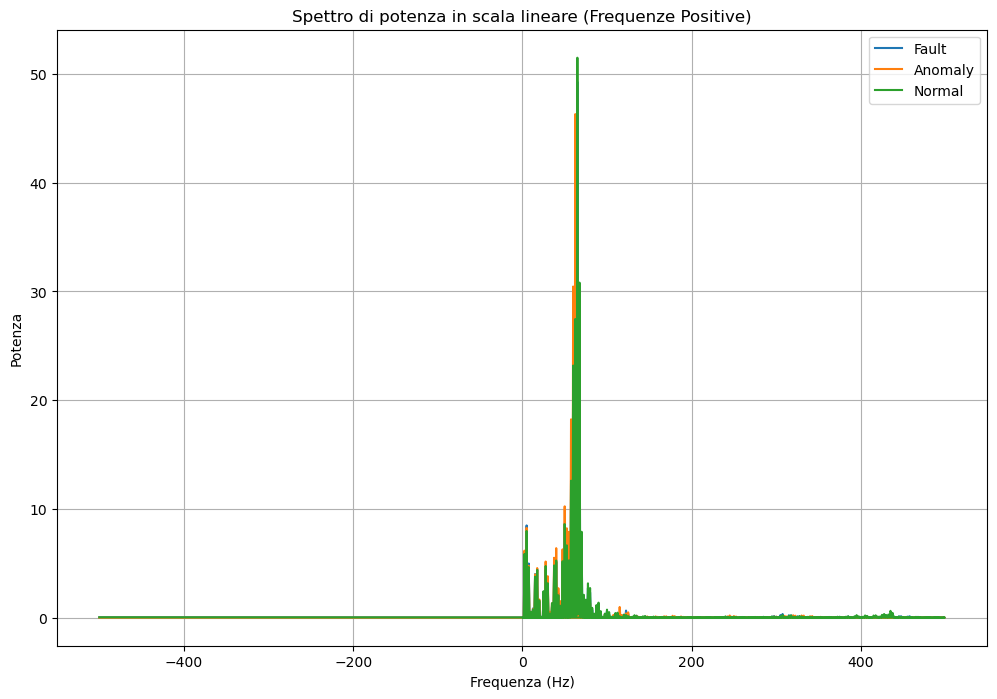

In [36]:
positive_freqs = freq[:signal_length_ms//2]
fft_fault_positive = fft_fault[:signal_length_ms//2]
fft_anomaly_positive = fft_anomaly[:signal_length_ms//2]
fft_normal_positive = fft_normal[:signal_length_ms//2]

power_spectrum_fault_positive = np.abs(fft_fault_positive) ** 2 / len(fft_fault_positive)
power_spectrum_anomaly_positive = np.abs(fft_anomaly_positive) ** 2 / len(fft_anomaly_positive)
power_spectrum_normal_positive = np.abs(fft_normal_positive) ** 2 / len(fft_normal_positive)

plt.figure(figsize=(12, 8))
plt.plot(positive_freqs, power_spectrum_fault_positive, label='Fault')
plt.plot(positive_freqs, power_spectrum_anomaly_positive, label='Anomaly')
plt.plot(positive_freqs, power_spectrum_normal_positive, label='Normal')
plt.title('Spettro di potenza in scala lineare (Frequenze Positive)')
plt.xlabel('Frequenza (Hz)')
plt.ylabel('Potenza')
plt.legend()
plt.grid()
plt.show()

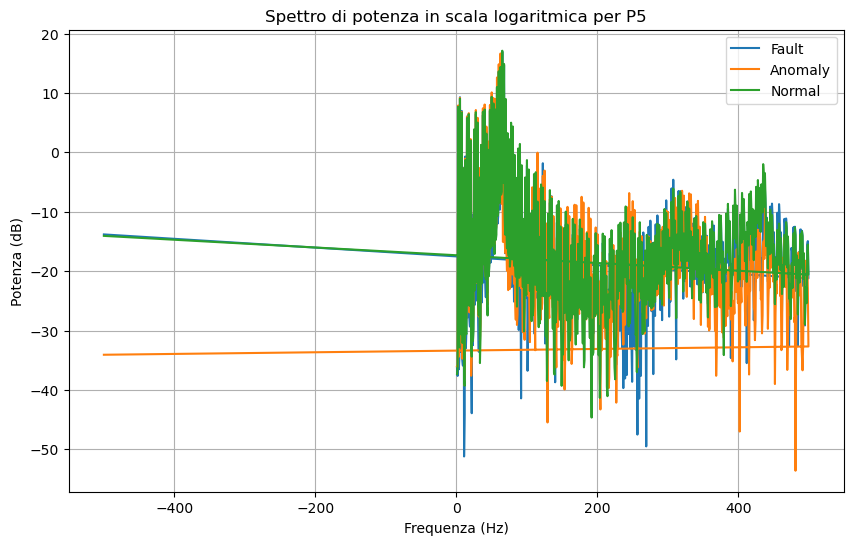

In [41]:
positive_freqs = freq[:signal_length_ms//2]
fft_fault_positive = fft_fault[:signal_length_ms//2]
fft_anomaly_positive = fft_anomaly[:signal_length_ms//2]
fft_normal_positive = fft_normal[:signal_length_ms//2]

power_spectrum_fault_positive = np.abs(fft_fault_positive) ** 2 / len(fft_fault_positive)
power_spectrum_anomaly_positive = np.abs(fft_anomaly_positive) ** 2 / len(fft_anomaly_positive)
power_spectrum_normal_positive = np.abs(fft_normal_positive) ** 2 / len(fft_normal_positive)

plt.figure(figsize=(10, 6))
plt.plot(positive_freqs, 10 * np.log10(power_spectrum_fault_positive), label='Fault')
plt.plot(positive_freqs, 10 * np.log10(power_spectrum_anomaly_positive), label='Anomaly')
plt.plot(positive_freqs, 10 * np.log10(power_spectrum_normal_positive), label='Normal')
plt.title('Spettro di potenza in scala logaritmica per P5')
plt.xlabel('Frequenza (Hz)')
plt.ylabel('Potenza (dB)')
plt.legend()
plt.grid()
plt.show()


In [38]:
trace_fault = go.Scatter(x=positive_freqs, y=power_spectrum_fault_positive, mode='lines', name='Fault')
trace_anomaly = go.Scatter(x=positive_freqs, y=power_spectrum_anomaly_positive, mode='lines', name='Anomaly')
trace_normal = go.Scatter(x=positive_freqs, y=power_spectrum_normal_positive, mode='lines', name='Normal')


layout = go.Layout(
    title='Spettro di potenza in scala lineare P5',
    xaxis=dict(title='Frequenza (Hz)'),
    yaxis=dict(title='Potenza'),
    legend=dict(x=0.01, y=0.99),
    margin=dict(l=40, r=0, t=40, b=30)
)

fig = go.Figure(data=[trace_fault, trace_anomaly, trace_normal], layout=layout)

fig.show()